# Conv1D + LSTM with Sunspot Dataset

- 태양 흑점의 변화를 기록한 시계열 데이터를 이용하여 RNN Regression으로 예측하는 문제  

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(51)
np.random.seed(51)

Data 읽어 오기

In [2]:
# df = pd.read_csv('datasets/sunspots.csv', 
df = pd.read_csv('sunspots.csv', 
                 index_col=0, parse_dates=['Date'])
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


Data 시각화

(3235,)


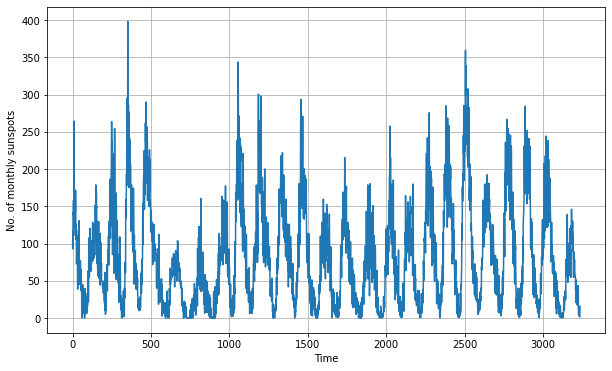

In [3]:
series = df['Monthly Mean Total Sunspot Number'].values
time = range(series.size)
print(series.shape)

plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("No. of monthly sunspots")
plt.grid(True)

train / valid dataset 분할

In [25]:
split_time = 3000
time_train = time[:split_time] 
x_train = series[:split_time] 
time_valid = time[split_time:] 
x_valid = series[split_time:] 

print(time_train, time_valid)
print(x_train.shape, x_valid.shape)

range(0, 3000) range(3000, 3235)
(3000,) (235,)


지도학습 dataset 변환 helper function
```
ds.map(lambda w: (w[:-1], w[1:]))
```
`w[-1]`을 target으로 하면 model은 window_size 전체를 예측하려 하지 않고 last value에 집중할 것이므로 `w[1:]`로 target을 주어 window 전체를 예측하도록 한다.


In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer=None):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    if shuffle_buffer:
        ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

prediction 을 위한 input data 변환 helper funtion

In [16]:
def model_forecast(model, series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    return forecast

model train

In [7]:
window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size)

print(train_set)
print(x_train.shape)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, 
                           strides=1, padding="causal", activation="relu", 
                           input_shape=[None, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

model.compile(loss='mse', optimizer='adam', metrics=["mae"])

history = model.fit(train_set, epochs=500, validation_data=valid_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/500
12/12 [==============================] - 6s 119ms/step - loss: 3487.5757 - mae: 43.2576 - val_loss: 987.6653 - val_mae: 22.8016
Epoch 2/500
12/12 [==============================] - 1s 32ms/step - loss: 1424.4740 - mae: 27.1524 - val_loss: 658.2660 - val_mae: 18.5970
Epoch 3/500
12/12 [==============================] - 1s 33ms/step - loss: 1020.0866 - mae: 22.7223 - val_loss: 464.4722 - val_mae: 15.6450
Epoch 4/500
12/12 [==============================] - 1s 32ms/step - loss: 804.2115 - mae: 20.2956 - val_loss: 461.0123 - val_mae: 15.4968
Epoch 5/500
12/12 [==============================] - 1s 33ms/step - loss: 701.8894 - mae: 19.0240 - val_loss: 406.2269 - val_mae: 14.4975
Epoch 6/500
12/12 [==============================] - 1s 31ms/step - loss: 660.8807 - mae: 18.5072 - val_loss: 437.8075 - val_mae: 14.7835
Epoch 7/500
12/12 [==============================] - 1s 33ms/step 

model을 이용한 forecast

model의 output은 (input 갯수, window_size, 1) 이므로 각 window step의 마지막 예측값만 select한다.

In [19]:
forecast = model_forecast(model, x_valid, window_size)
forecast = forecast[:, -1, 0]
print(forecast.shape)

(172,)


### True value와 Prediction 비교 - 시각화

In [23]:
time_valid

range(3000, 3235)

forecast 는 초반 window_size 만큼을 skip 하여 시각화

In [27]:
time[split_time+window_size:] 

range(3064, 3235)

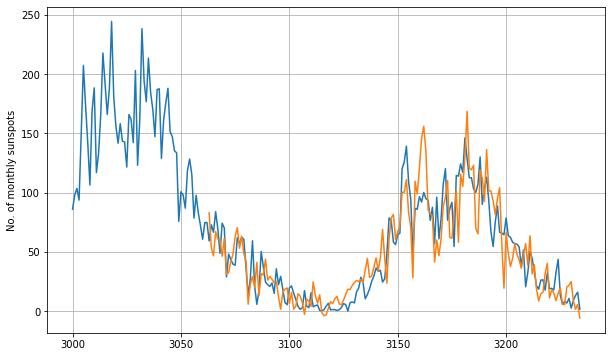

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid)
plt.plot(time[split_time+window_size-1:] , forecast)
plt.ylabel("No. of monthly sunspots")

plt.grid(True)

Metric 출력

In [34]:
history.history['val_mae'][-1]

19.499204635620117